In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
# Read the data from a CSV file and select relevant columns
df_queries = pd.read_csv('antique_query_test.csv')
df_queries = df_queries[['query_id','text']]

df_docs = pd.read_csv('antique_sample_404k.csv')
df_docs = df_docs[['doc_id','text']]

df_qrel = pd.read_csv('antique_qurel_test.csv')
df_qrel = df_qrel[['query_id','doc_id','relevance']]

In [3]:
# Define a function to map relevance values to binary labels
def map_values(value):
    if value in [3, 4]:
        return 1
    else:
        return 0

In [4]:
# Apply the mapping function to create binary labels and add to the relevance data
df_qrel['label'] = df_qrel['relevance'].apply(map_values)

# Drop duplicate entries based on query_id and doc_id in the relevance data
df_qrel1 = df_qrel.drop_duplicates(subset=['query_id','doc_id'])
df_qrel1

,query_id,doc_id,relevance,label
0,1964316,1964316_5,4,1
1,1964316,1674088_11,1,0
2,1964316,1218838_13,2,0
3,1964316,1519022_15,2,0
4,1964316,3059341_5,2,0
...,...,...,...,...
6584,1262692,247023_6,3,1
6585,1262692,1499030_5,3,1
6586,1262692,2916758_0,3,1
6587,1262692,1105845_15,3,1


In [5]:
# Merge the query data and relevance data based on query_id
merged_df = df_queries.merge(df_qrel1, on='query_id', how='left')

# Drop duplicate entries based on query_id and doc_id in the merged data
merged_df = merged_df.drop_duplicates(subset=['query_id','doc_id'])
merged_df

,query_id,text,doc_id,relevance,label
0,3990512,how can we get concentration onsomething?,3990512_1,4,1
1,3990512,how can we get concentration onsomething?,2036065_1,2,0
2,3990512,how can we get concentration onsomething?,3265991_12,2,0
3,3990512,how can we get concentration onsomething?,3149758_0,1,0
4,3990512,how can we get concentration onsomething?,3990512_0,3,1
...,...,...,...,...,...
6584,1971899,what is masturbat***?,1971899_6,2,0
6585,1971899,what is masturbat***?,1971899_7,2,0
6586,1971899,what is masturbat***?,1971899_1,4,1
6587,1971899,what is masturbat***?,1971899_2,1,0


## Basic EDA

In [6]:
# Create a DataFrame for exploratory data analysis (EDA) with relevant columns
eda_df =  merged_df[['query_id','doc_id','label']]

# Print basic information about the EDA DataFrame
print("Basic Information:")
print(eda_df.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   query_id  6589 non-null   int64 
 1   doc_id    6589 non-null   object
 2   label     6589 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 154.6+ KB
None


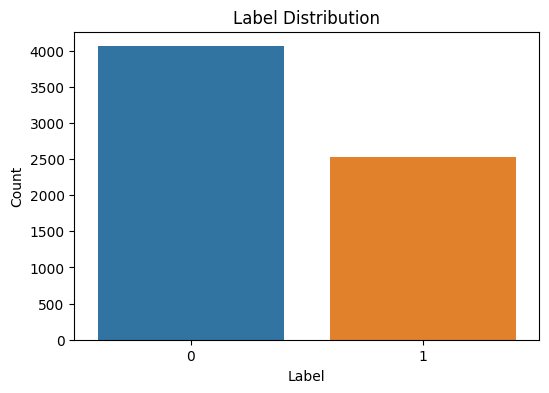

In [7]:
# Count the occurrences of each label and visualize the label distribution
label_counts = eda_df['label'].value_counts()

plt.figure(figsize=(6, 4))
sns.countplot(data=eda_df, x='label')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [8]:
# Calculate and display the number of unique query_ids and doc_ids
unique_query_ids = eda_df['query_id'].nunique()
unique_doc_ids = eda_df['doc_id'].nunique()
print(f"\nNumber of unique query_ids: {unique_query_ids}")
print(f"Number of unique doc_ids: {unique_doc_ids}")


Number of unique query_ids: 200
Number of unique doc_ids: 6486


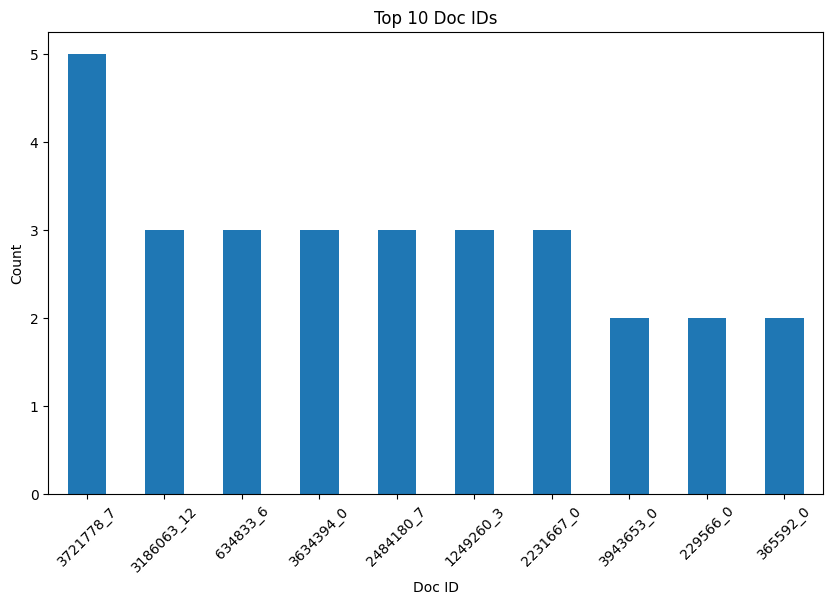

In [9]:
# Visualize the top 10 most common doc_ids
top_doc_ids = eda_df['doc_id'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_doc_ids.plot(kind='bar')
plt.title("Top 10 Doc IDs")
plt.xlabel("Doc ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [10]:
# Group data by query_id and calculate the count of documents per query
doc_count_per_query = eda_df.groupby('query_id')['doc_id'].count().reset_index(name='doc_count')

# Sort the results by document count in descending order
doc_count_per_query.sort_values(by='doc_count', ascending=[False])

,query_id,doc_count
173,4018891,84
194,4406669,68
191,4372730,64
79,1866981,64
41,922849,60
...,...,...
197,4467100,12
192,4377861,9
146,3382736,9
11,224109,4


In [11]:
# Group data by query_id and calculate various statistics
doc_count_per_query = eda_df.groupby('query_id').agg(doc_count=('doc_id', 'count'),
                                                      label_1_count=('label', 'sum'),
                                                      label_0_count=('label', lambda x: (x == 0).sum()),
                                                      ).reset_index()

# Sort the results by document count in descending order
sorted_doc_count_per_query = doc_count_per_query.sort_values(by='doc_count', ascending=False)

sorted_doc_count_per_query

,query_id,doc_count,label_1_count,label_0_count
173,4018891,84,35,49
194,4406669,68,41,27
191,4372730,64,28,36
79,1866981,64,19,45
41,922849,60,25,35
...,...,...,...,...
197,4467100,12,1,11
192,4377861,9,4,5
146,3382736,9,4,5
11,224109,4,1,3


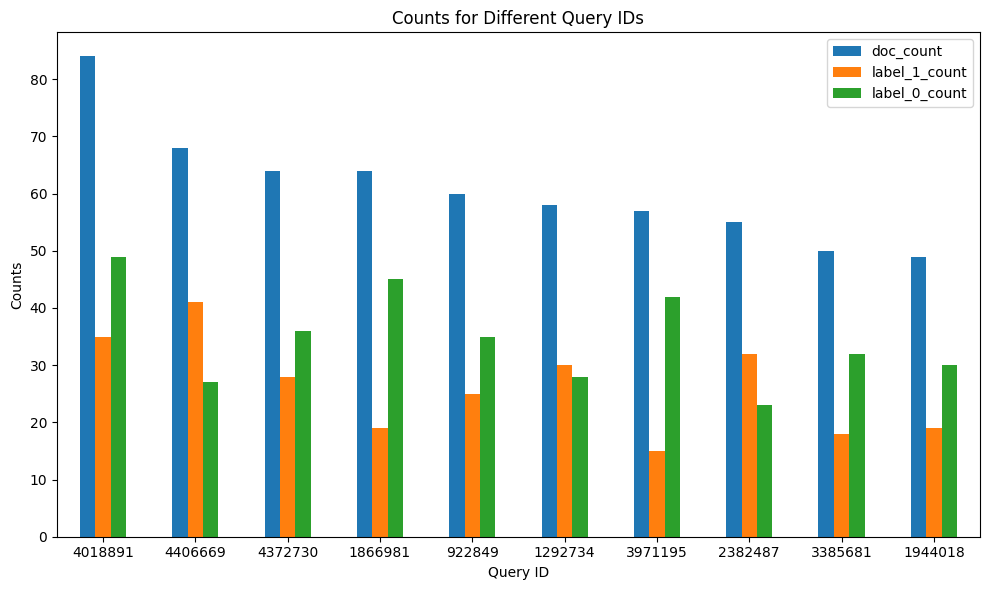

In [12]:
# Select the top 10 query_ids by document count
sorted_doc_count_per_query = sorted_doc_count_per_query.head(10)
sorted_doc_count_per_query.set_index('query_id', inplace=True)

# Visualize the document count and label statistics for the top 10 query_ids
ax = sorted_doc_count_per_query.plot(kind='bar', figsize=(10, 6))
ax.set_ylabel('Counts')
ax.set_xlabel('Query ID')
ax.set_title('Counts for Different Query IDs')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
# Merge the previously merged DataFrame with the document data based on doc_id
merged_df_docs = merged_df.merge(df_docs, on='doc_id', how='left')

In [14]:
stop_words_list = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
    'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
    'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by',
    'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
    'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
    'will', 'just', 'don', 'should', 'now'
]

## Analysis on Docs

In [15]:
#Function to perform Text Analysis

def perform_text_eda(dataframe, text_column, custom_stopwords=None):
    # Function to preprocess text
    def preprocess_text(text):
        # Remove punctuation and symbols using regular expressions
        cleaned_text = re.sub(r'[^\w\s]', '', text)
        return cleaned_text
    
    # Apply preprocessing to text column
    dataframe['cleaned_text'] = dataframe[text_column].apply(preprocess_text)
    
    # Calculate word and character counts
    dataframe['word_count'] = dataframe['cleaned_text'].apply(lambda x: len(word_tokenize(x)))
    dataframe['char_count'] = dataframe['cleaned_text'].apply(lambda x: len(x))
    
    # Calculate word frequency distribution
    words = word_tokenize(' '.join(dataframe['cleaned_text']))
    fdist = FreqDist(words)
    
    # Apply stopwords if provided
    if custom_stopwords:
        filtered_words = [[word for word in word_tokenize(text) if word.lower() not in custom_stopwords] for text in dataframe['cleaned_text']]
        fdist_filtered = FreqDist([word for sublist in filtered_words for word in sublist])
    else:
        filtered_words = words
        fdist_filtered = fdist
    
    # Display statistics
    print(dataframe[['word_count', 'char_count']].describe())
    print("Top 10 most common words:")
    print(fdist.most_common(10))
    print("Top 10 most common non-stopwords:")
    print(fdist_filtered.most_common(10))
    
    # Plot text length distribution
    plt.hist(dataframe['word_count'], bins=20, color='c', edgecolor='black')
    plt.xlabel('Text Length (Word Count)')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution')
    plt.show()
    
    # TF-IDF Vectorization (number_of_documents, number_of_unique_words)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(text) for text in filtered_words])
    print("TF-IDF Matrix shape:", tfidf_matrix.shape)
    
    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist_filtered)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud')
    plt.show()
    
    def calculate_sentiment(text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    
    dataframe['sentiment'] = dataframe['cleaned_text'].apply(calculate_sentiment)
    print(dataframe[['sentiment']].describe())
    plt.hist(dataframe['sentiment'], bins=20, color='c', edgecolor='black')
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.title('Sentiment Distribution')
    plt.show()


        word_count   char_count
count  6589.000000  6589.000000
mean     45.589164   247.380483
std      56.968753   323.042317
min       1.000000     3.000000
25%      15.000000    78.000000
50%      31.000000   164.000000
75%      56.000000   302.000000
max     719.000000  3898.000000
Top 10 most common words:
[('the', 13013), ('to', 8052), ('and', 7304), ('a', 7062), ('of', 6232), ('is', 5524), ('you', 4695), ('in', 4138), ('it', 3837), ('that', 3525)]
Top 10 most common non-stopwords:
[('people', 1144), ('dont', 1057), ('like', 999), ('get', 981), ('would', 732), ('one', 723), ('know', 714), ('think', 699), ('make', 559), ('go', 536)]


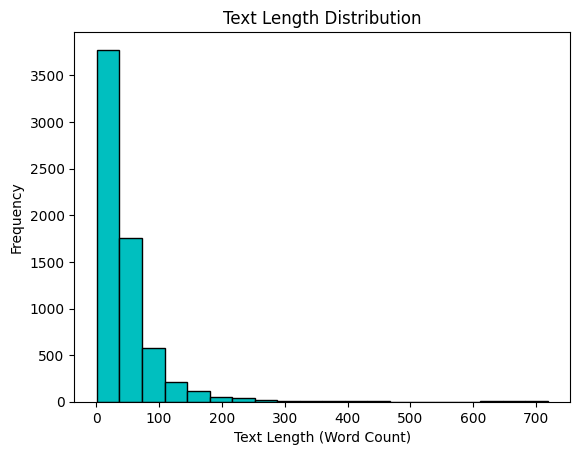

TF-IDF Matrix shape: (6589, 22012)


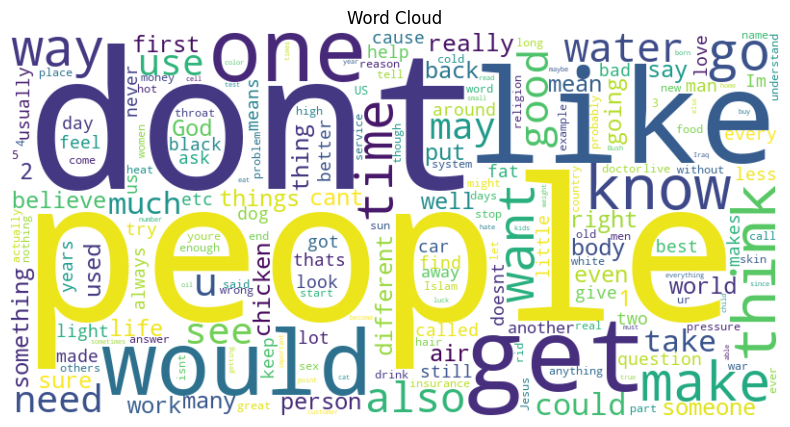

         sentiment
count  6589.000000
mean      0.073420
std       0.242346
min      -1.000000
25%      -0.004167
50%       0.016786
75%       0.200000
max       1.000000


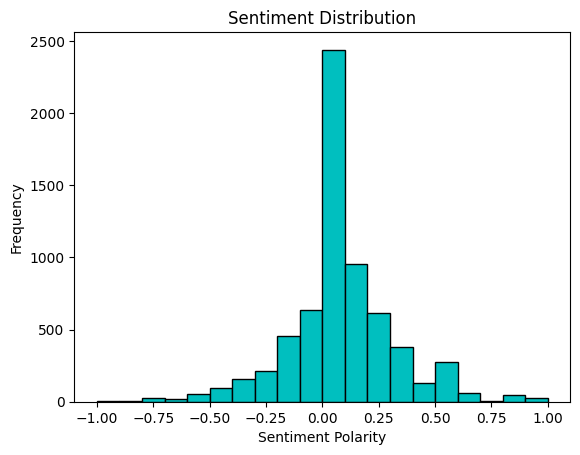

In [16]:

custom_stopwords = set(stop_words_list)

# Call the function
perform_text_eda(merged_df_docs, 'text_y', custom_stopwords)


In [17]:
merged_df_docs.head(3)

,query_id,text_x,doc_id,relevance,label,text_y,cleaned_text,word_count,char_count,sentiment
0,3990512,how can we get concentration onsomething?,3990512_1,4,1,"For one thing, focus on what you want to achie...",For one thing focus on what you want to achiev...,51,296,0.25
1,3990512,how can we get concentration onsomething?,2036065_1,2,0,just by concentration,just by concentration,3,21,0.00
2,3990512,how can we get concentration onsomething?,3265991_12,2,0,concentration,concentration,1,13,0.00


In [18]:
# Load pre-computed document embeddings
import pickle
with open('corpus_embeddings_text.pickle', 'rb') as pkl:
    doc_embedding = pickle.load(pkl)

In [19]:
# Initialize SentenceTransformer for embedding
bi_encoder = SentenceTransformer('intfloat/e5-base-v2')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
# top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

In [20]:
# cosine_similarities = cosine_similarity(doc_embedding)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
# pca_embeddings = pca.fit_transform(cosine_similarities)

pca_embeddings = pca.fit_transform(doc_embedding)

In [21]:
# Apply KMeans clustering
num_clusters = 200  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(doc_embedding)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [22]:
# Create a list to store the coordinates and doc_ids
coordinates = []
doc_ids_list = []

for cluster_id in range(num_clusters):
    cluster_points = pca_embeddings[cluster_labels == cluster_id]
    doc_ids = merged_df_docs['doc_id'][cluster_labels == cluster_id]
    
    for i, (x, y) in enumerate(cluster_points):
        coordinates.append((x, y))
        doc_ids_list.append(doc_ids.iloc[i])

# Create a DataFrame with the coordinates and doc_ids
doc_coordinates_df = pd.DataFrame(coordinates, columns=['PCA_Component_1', 'PCA_Component_2'])
doc_coordinates_df['doc_id'] = doc_ids_list



In [23]:
doc_coordinates_df.to_csv('doc_coordinates.csv', index=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


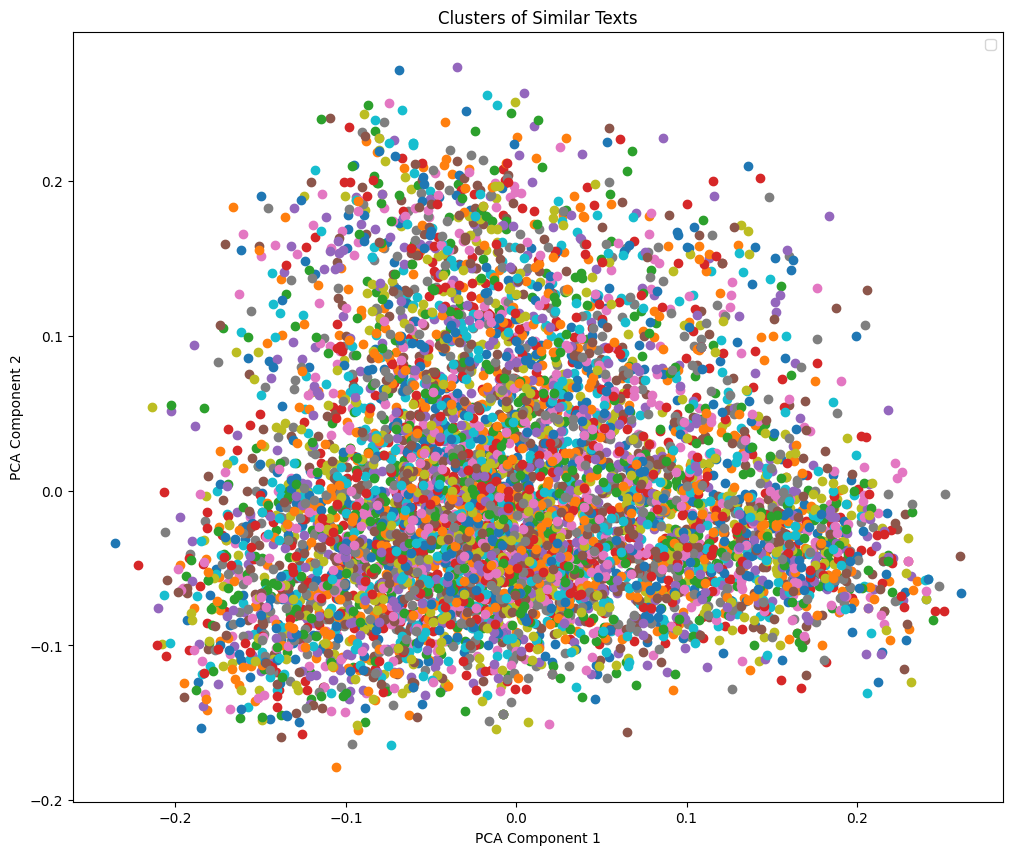

In [24]:
# Create a scatter plot with annotations
plt.figure(figsize=(12, 10))

for cluster_id in range(num_clusters):
    cluster_points = pca_embeddings[cluster_labels == cluster_id]
    doc_ids = merged_df_docs['doc_id'][cluster_labels == cluster_id]
    
    for i, (x, y) in enumerate(cluster_points):
        plt.scatter(x, y)#, label=f'Cluster {cluster_id}' if i == 0 else "", color=plt.cm.jet(cluster_id / num_clusters))
        # plt.annotate(doc_ids.iloc[i], (x, y), fontsize=8, alpha=0.7)

plt.title('Clusters of Similar Texts')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [25]:
# # Create a scatter plot with annotations
# plt.figure(figsize=(12, 10))

# for cluster_id in range(num_clusters):
#     cluster_points = pca_embeddings[cluster_labels == cluster_id]
#     doc_ids = merged_df_docs['doc_id'][cluster_labels == cluster_id]
    
#     for i, (x, y) in enumerate(cluster_points):
#         plt.scatter(x, y)#, label=f'Cluster {cluster_id}' if i == 0 else "", color=plt.cm.jet(cluster_id / num_clusters))
#         # plt.annotate(doc_ids.iloc[i], (x, y), fontsize=8, alpha=0.7)

# plt.title('Clusters of Similar Texts with Doc IDs')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.legend()
# plt.show()

## Analysis on Queries

       word_count  char_count
count  200.000000  200.000000
mean     9.240000   46.900000
std      4.066334   21.214862
min      3.000000   13.000000
25%      6.000000   31.000000
50%      8.000000   42.500000
75%     11.250000   59.000000
max     20.000000  107.000000
Top 10 most common words:
[('the', 68), ('do', 60), ('Why', 52), ('is', 52), ('a', 47), ('to', 43), ('how', 36), ('How', 36), ('of', 33), ('what', 33)]
Top 10 most common non-stopwords:
[('people', 17), ('get', 16), ('mean', 9), ('make', 8), ('like', 7), ('rid', 6), ('dont', 6), ('know', 5), ('without', 5), ('black', 5)]


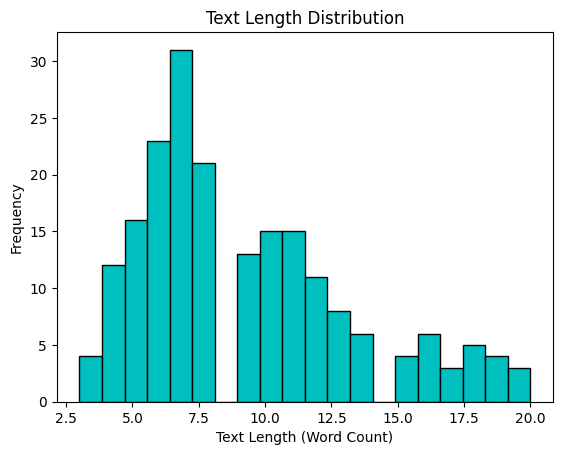

TF-IDF Matrix shape: (200, 684)


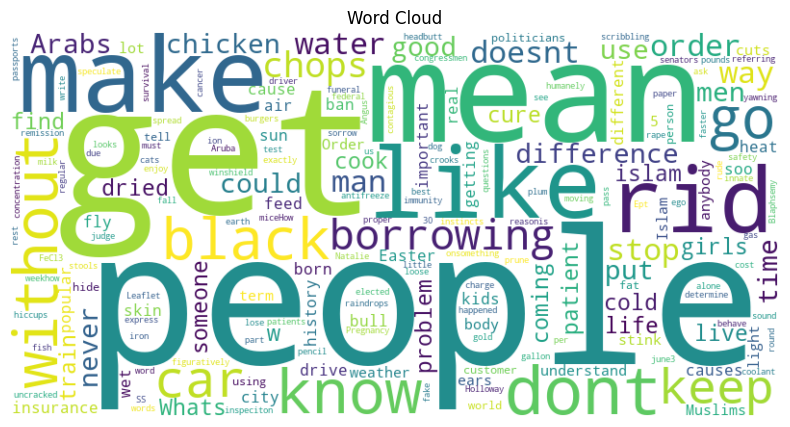

        sentiment
count  200.000000
mean     0.020722
std      0.250974
min     -0.900000
25%      0.000000
50%      0.000000
75%      0.000000
max      0.850000


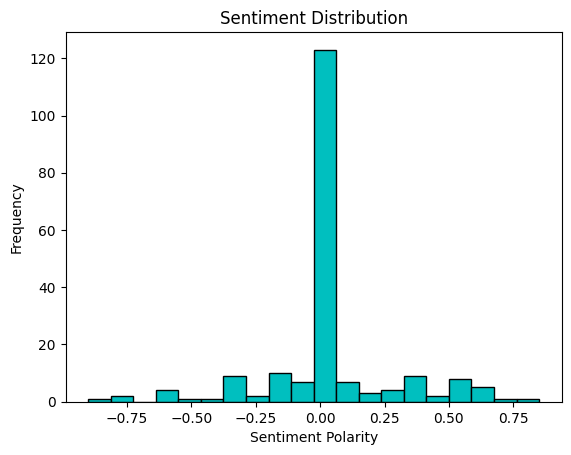

In [26]:
# Call the function
perform_text_eda(df_queries, 'text', custom_stopwords)


In [27]:
df_queries.head(3)

,query_id,text,cleaned_text,word_count,char_count,sentiment
0,3990512,how can we get concentration onsomething?,how can we get concentration onsomething,6,40,0.0
1,714612,Why doesn't the water fall off earth if it's ...,Why doesnt the water fall off earth if its round,10,49,-0.2
2,2528767,How do I determine the charge of the iron ion ...,How do I determine the charge of the iron ion ...,12,54,0.0


In [28]:
# Load pre-computed document embeddings
import pickle
with open('query_embeddings.pickle', 'rb') as pkl:
    query_embeddings = pickle.load(pkl)

In [29]:
# cosine_similarities = cosine_similarity(query_embeddings)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(query_embeddings)
# pca_embeddings = pca.fit_transform(cosine_similarities)

In [30]:
# Apply KMeans clustering
num_clusters = 10 # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(query_embeddings)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
# Create a list to store the coordinates and doc_ids
coordinates = []
query_ids_list = []

for cluster_id in range(num_clusters):
    cluster_points = pca_embeddings[cluster_labels == cluster_id]
    query_ids = df_queries['query_id'][cluster_labels == cluster_id]
    
    for i, (x, y) in enumerate(cluster_points):
        coordinates.append((x, y))
        query_ids_list.append(query_ids.iloc[i])

# Create a DataFrame with the coordinates and doc_ids
query_coordinates_df = pd.DataFrame(coordinates, columns=['PCA_Component_1', 'PCA_Component_2'])
query_coordinates_df['query_id'] = query_ids_list

In [32]:
query_coordinates_df.to_csv('query_coordinates.csv', index=False)

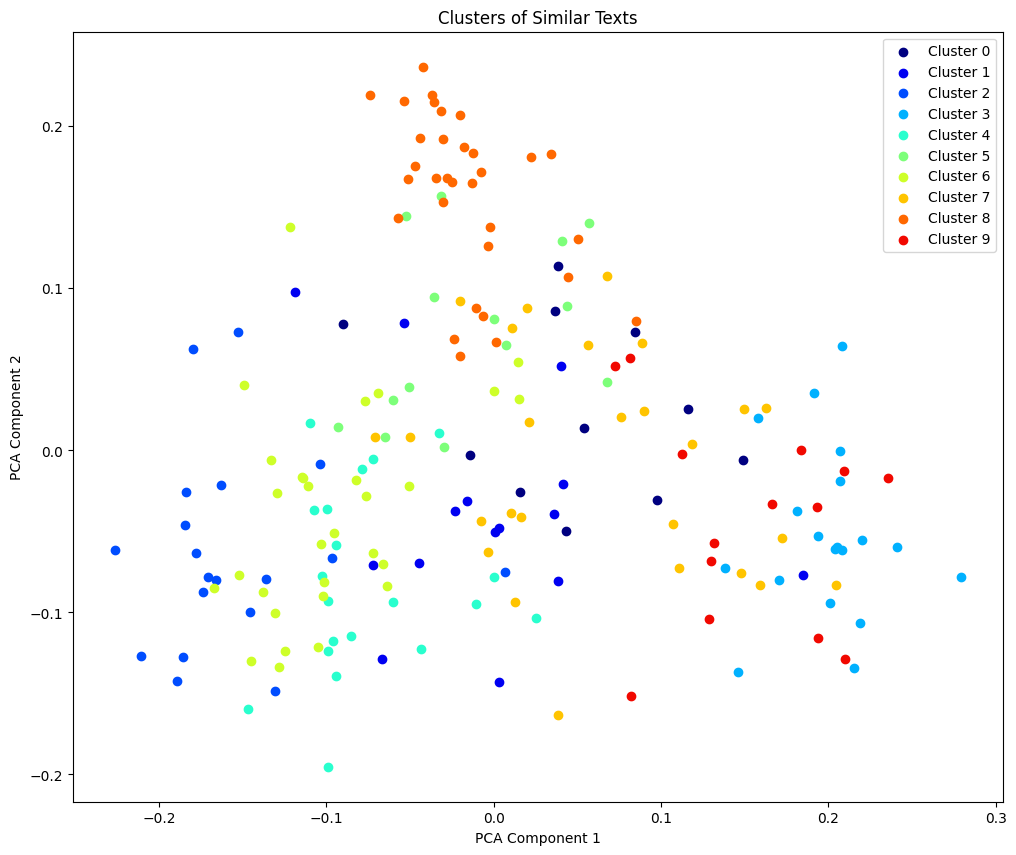

In [33]:

# Create a scatter plot with annotations
plt.figure(figsize=(12, 10))

for cluster_id in range(num_clusters):
    cluster_points = pca_embeddings[cluster_labels == cluster_id]
    query_ids = df_queries['query_id'][cluster_labels == cluster_id]
    
    for i, (x, y) in enumerate(cluster_points):
        plt.scatter(x, y, label=f'Cluster {cluster_id}' if i == 0 else "", color=plt.cm.jet(cluster_id / num_clusters))
        # plt.annotate(query_ids.iloc[i], (x, y), fontsize=8, alpha=0.7)

plt.title('Clusters of Similar Texts')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()